In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns

[*********************100%%**********************]  18 of 18 completed


<Axes: title={'center': 'Expected Annual Return'}, xlabel='Stocks', ylabel='Return (%)'>

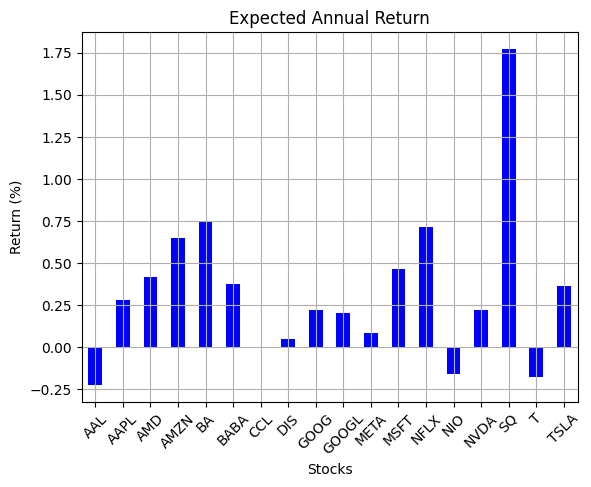

In [39]:
stocks = ["AAPL", "NVDA", "NIO", "META", "AMZN", "TSLA", "GOOGL", "MSFT",
          "AMD", "BA", "BABA", "T", "NFLX", "DIS", "GOOG", "SQ", "CCL", "AAL" ]

data = yf.download(stocks, start="2017-01-01", end="2019-01-01")['Adj Close']

returns = data.pct_change().apply(lambda x: np.log(1+x))

e_r = (1  + returns.mean())**365 -1

e_r.plot(kind='bar', title='Expected Annual Return',xlabel='Stocks', ylabel='Return (%)', grid="True", color='blue',rot=45 )

<Axes: title={'center': 'Expected Annual Variance'}, xlabel='Ticker'>

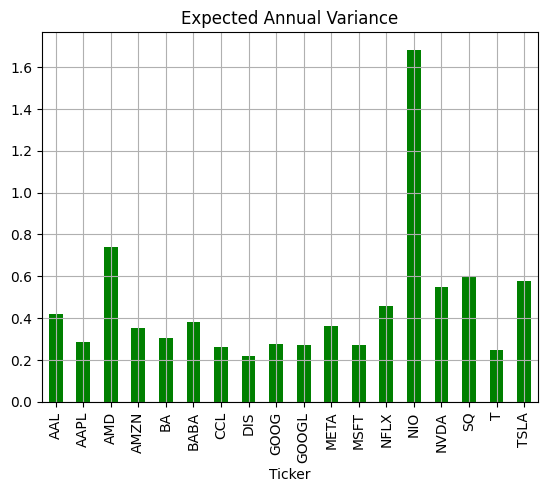

In [40]:
sd = returns.std()*np.sqrt(365.25) 
sd.plot(kind="bar", color="green", grid=True, title="Expected Annual Variance") 

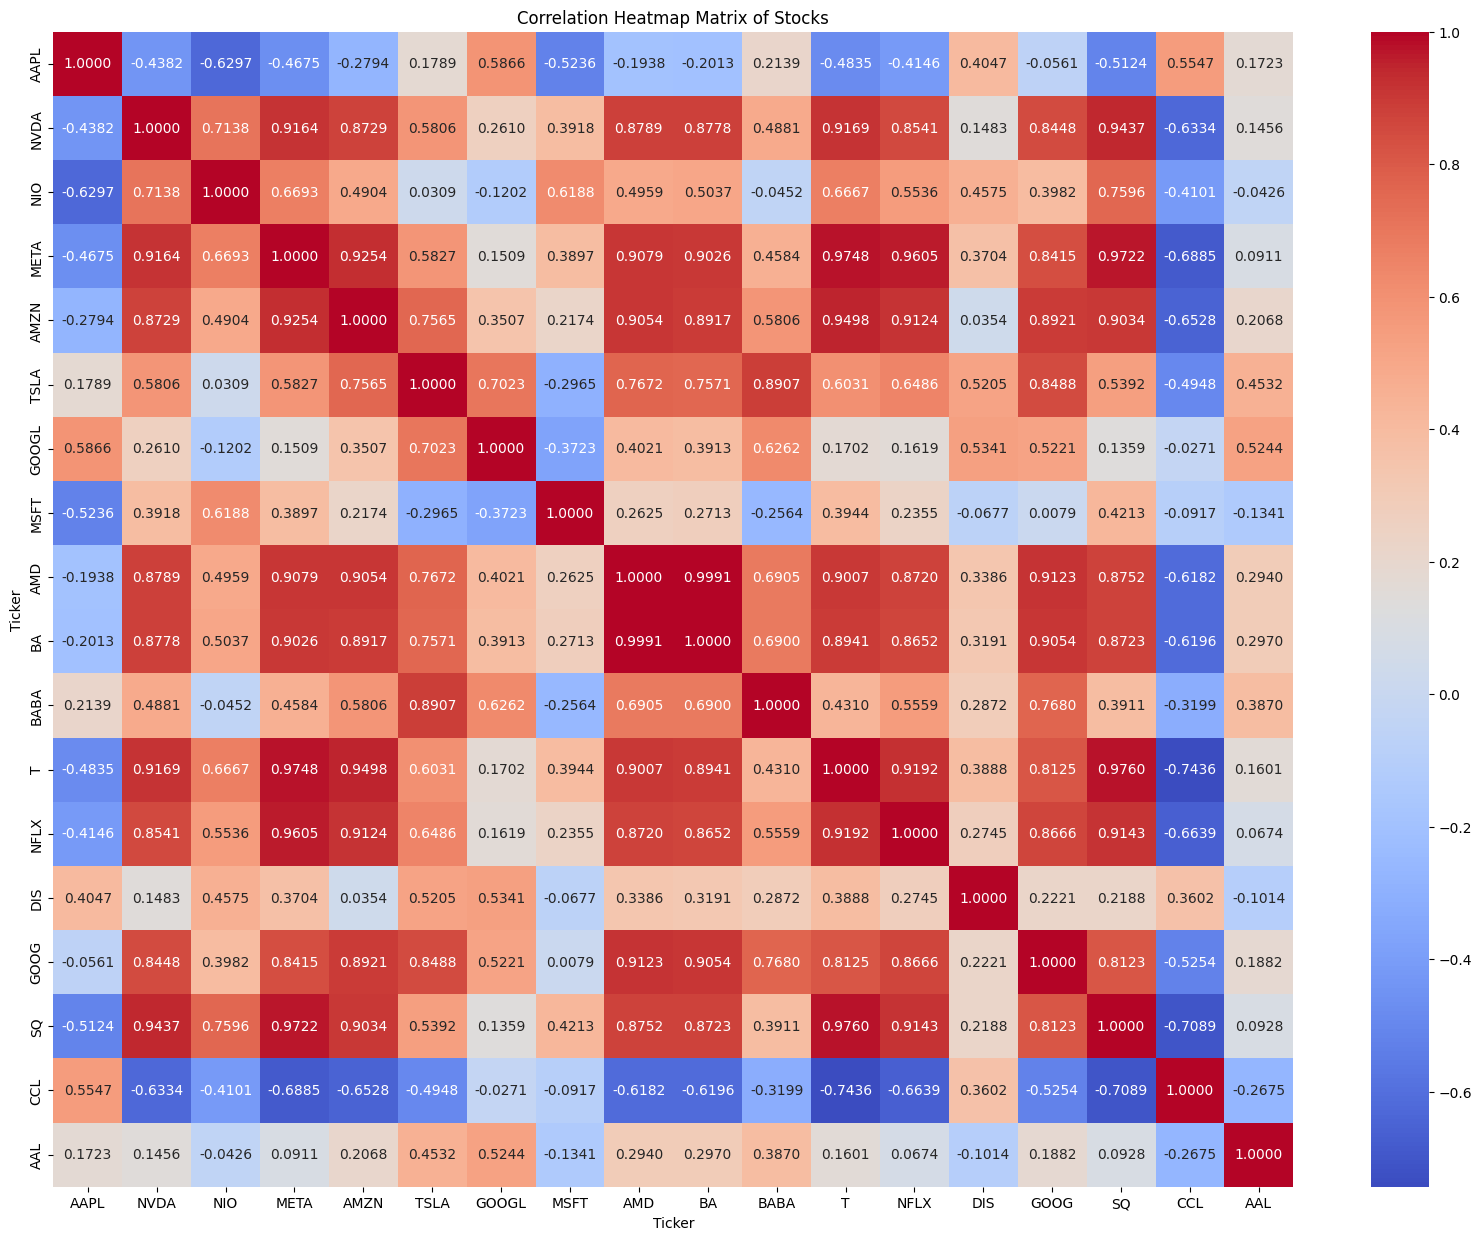

In [41]:
# Compute daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(), annot=True, fmt='.4f', cmap='coolwarm', xticklabels=stocks, yticklabels=stocks)
plt.title('Correlation Heatmap Matrix of Stocks')
plt.show()

In [42]:
# Convert mean returns and covariance matrix to dictionaries
mean_return_dict = {i: mean_returns[i] for i in range(len(mean_returns))}
cov_dict = {(i, j): cov_matrix.values[i][j] for i in range(len(stocks)) for j in range(len(stocks))}

# Create a Gurobi model
m = gp.Model("transaction_costless_portfolio_optimization")

# Decision variables: Proportion of investment in each stock
weights = m.addVars(len(stocks), lb=-1, ub=1, name="weights")

# Constraint: Sum of weights is 1 (fully invested portfolio)
m.addConstr(weights.sum() == 1, "full_investment")

# Prepare to collect efficient frontier points
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 70)
risks = []

for target_return in target_returns:
    # Constraint: Achieve target return
    m.addConstr(sum(weights[i] * mean_return_dict[i] for i in range(len(stocks))) >= target_return, "target_return")
    
    # Objective: Minimize the portfolio variance
    portfolio_variance = sum(weights[i] * weights[j] * cov_dict[i, j] for i in range(len(stocks)) for j in range(len(stocks)))
    m.setObjective(portfolio_variance, GRB.MINIMIZE)
    
    # Optimize the model
    m.optimize()

    if m.status == GRB.OPTIMAL:
        risks.append(np.sqrt(portfolio_variance.getValue()))
        optimal_weights = m.getAttr('x', weights)
        print(f"Target Return: {target_return:.2%}")
        print("Portfolio Weights:")
        for i in weights:
            print(f"{stocks[i]}: {optimal_weights[i]:.2%}")
    else:
        print("Optimal solution was not found for target return:", target_return)
    
    # Remove the target return constraint to iterate for the next return
    m.remove(m.getConstrByName("target_return"))

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C5030f)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 18 columns and 36 nonzeros
Model fingerprint: 0xde5329e9
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 18 columns, 36 nonzeros
Presolved model has 171 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 17
 AA' NZ     : 1.710e+02
 Factor NZ  : 1.900e+02
 Factor Ops : 2.470e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.12054231e+03 -2.31300472e+03  1.33e+04 5.40e+02  1.00e+06     

/var/folders/_y/6dhssjqn2c77c1wvk8fd4nsc0000gn/T/ipykernel_42152/1319973125.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_return_dict = {i: mean_returns[i] for i in range(len(mean_returns))}



CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 18 columns and 36 nonzeros
Model fingerprint: 0xc7c43224
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 18 columns, 36 nonzeros
Presolved model has 171 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 17
 AA' NZ     : 1.710e+02
 Factor NZ  : 1.900e+02
 Factor Ops : 2.470e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.12054229e+03 -2.31300469e+03  1.33e+04 5.40e+02  1.00e+06     0s
   1   9.39641233e+00 -2.01778514e+02  2.53e+02 1.03e+01  1.98e+04     0s
   2   1.6

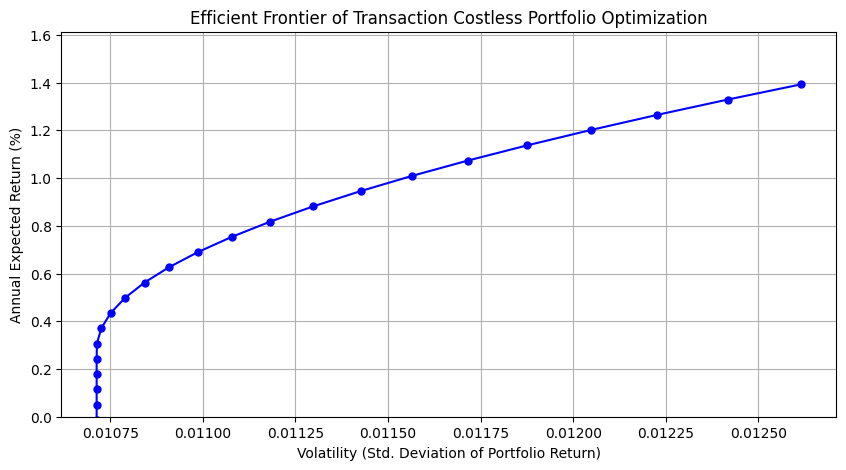

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(risks, target_returns*365.25, marker='o', linestyle='-', color='b', markersize=5, scalex=True)
plt.title('Efficient Frontier of Transaction Costless Portfolio Optimization')
plt.xlabel('Volatility (Std. Deviation of Portfolio Return)')
plt.ylabel('Annual Expected Return (%)')
plt.grid(True)
plt.ylim(bottom=0)  # Set the y-axis lower limit to 0
plt.show()


In [44]:
import yfinance as yf
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Fetch stock data
stocks_a = ["AAPL", "NVDA", "NIO", "META", "AMZN", "TSLA", "GOOGL", "MSFT",
          "AMD", "BA", "BABA", "T", "NFLX", "DIS", "GOOG", "SQ", "CCL", "AAL" ]

df_a = yf.download(stocks_a, start="2017-01-01", end="2019-01-01")['Adj Close']

# Compute daily returns
returns_a = df_a.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns_a = returns_a.mean()
cov_matrix_a = returns_a.cov()

# Prepare to collect efficient frontier points
target_returns_a = np.linspace(mean_returns_a.min(), mean_returns_a.max(), 50)
risks_a = []
returns_on_ef_a = []

for target_return_a in target_returns_a:
    # Create a Gurobi model
    mm_a = gp.Model("portfolio_optimization_a")

    # Decision variables: Proportion of investment in each stock
    weights_a = mm_a.addVars(len(stocks_a), lb=0, ub=1, name="weights_a")
    
    # Constraint: Sum of weights is 1 (fully invested portfolio)
    mm_a.addConstr(weights_a.sum() == 1, "full_investment_a")
    
    # Constraint: Achieve target return
    mm_a.addConstr(sum(weights_a[i] * mean_returns_a[i] for i in range(len(stocks_a))) >= target_return_a)
    
    # Calculate the portfolio variance (objective function part 1)
    portfolio_variance_a = sum(weights_a[i] * weights_a[j] * cov_matrix_a.iloc[i, j] for i in range(len(stocks_a)) for j in range(len(stocks_a)))
    
    # Auxiliary variables for absolute transaction amounts
    transaction_costs_a = mm_a.addVars(len(stocks_a), lb=0, name="transaction_costs_a")

    fixed_costs_a = mm_a.addVars(len(stocks_a), lb=0, name="fixed_costs_a")

    # Add fixed transaction cost if weight is greater than 0
    for i in range(len(stocks_a)):
        mm_a.addGenConstrIndicator(weights_a[i], True, fixed_costs_a[i] == weights_a[i] * 0)
        mm_a.addGenConstrIndicator(weights_a[i], False, transaction_costs_a[i] == weights_a[i] * 0.01)
    
    total_fixed_costs_a = sum(fixed_costs_a[i] for i in range(len(stocks_a)))


    # Assuming a 100% transaction fee for simplification, otherwise, replace 1 with the actual transaction fee percentage
    for i in range(len(stocks_a)):
        mm_a.addConstr(transaction_costs_a[i] >= (weights_a[i] - 0))
        mm_a.addConstr(transaction_costs_a[i] >= -(weights_a[i] - 0))

    total_transaction_costs_a = sum(transaction_costs_a[i] for i in range(len(stocks_a)))

    # Objective: Minimize the portfolio variance plus transaction costs
    mm_a.setObjective(portfolio_variance_a  , GRB.MINIMIZE)

    # Optimize the model
    mm_a.optimize()

    # Collect the results for the efficient frontier
    if mm_a.status == GRB.OPTIMAL:
        risks_a.append(np.sqrt(portfolio_variance_a.getValue()))
        returns_on_ef_a.append(target_return_a)
        print(f"Target Return: {target_return:.2%}")
        print("Portfolio Weights:")
        for i in weights:
            print(f"{stocks[i]}: {optimal_weights[i]:.2%}")
    else:
        print("Optimal solution was not found for target return:", target_return)

[*********************100%%**********************]  18 of 18 completed

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C5030f)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 38 rows, 54 columns and 108 nonzeros
Model fingerprint: 0xfc53360e
Model has 171 quadratic objective terms
Model has 36 general constraints
Variable types: 54 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+00]
  GenCon coe range [1e-02, 1e+00]
Presolve removed 37 rows and 36 columns
Presolve time: 0.00s
Presolved: 1 rows, 18 columns, 18 nonzeros
Presolved model has 171 quadratic objective terms
Variable types: 0 continuous, 18 integer (18 binary)
Found heuristic solution: objective 0.0010592

Root relaxation: objective 2.067345e-04, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node  


/var/folders/_y/6dhssjqn2c77c1wvk8fd4nsc0000gn/T/ipykernel_42152/1098804885.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mm_a.addConstr(sum(weights_a[i] * mean_returns_a[i] for i in range(len(stocks_a))) >= target_return_a)


Target Return: 0.38%
Portfolio Weights:
AAPL: -10.98%
NVDA: -49.63%
NIO: 6.78%
META: -24.79%
AMZN: 45.16%
TSLA: 11.98%
GOOGL: 3.47%
MSFT: 74.08%
AMD: -31.63%
BA: 99.99%
BABA: -5.81%
T: 13.03%
NFLX: -18.16%
DIS: 0.72%
GOOG: -14.18%
SQ: -12.70%
CCL: 7.90%
AAL: 4.75%
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C5030f)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 38 rows, 54 columns and 108 nonzeros
Model fingerprint: 0xca0f2ee1
Model has 171 quadratic objective terms
Model has 36 general constraints
Variable types: 54 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 1e+00]
  GenCon coe range [1e-02, 1e+00]
Presolve removed 37 rows and 37 columns
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Pres

[*********************100%%**********************]  10 of 10 completed


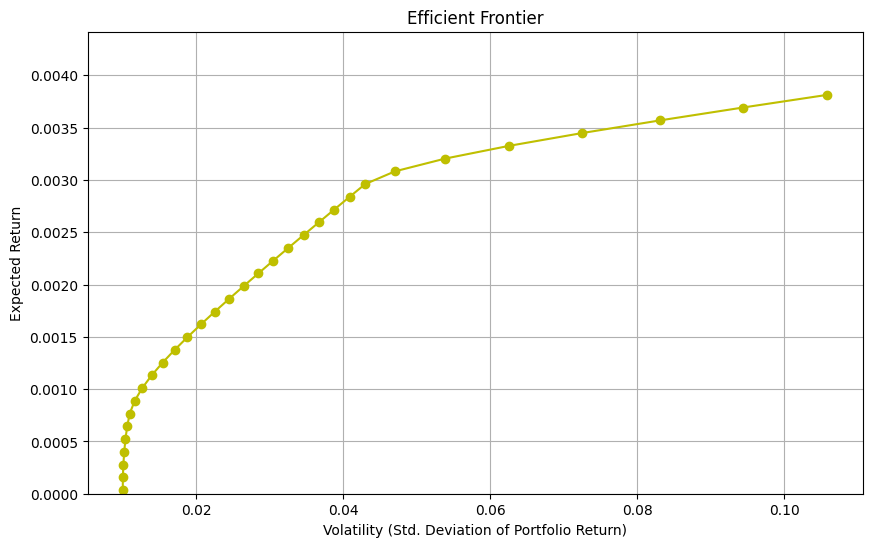

In [45]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Download stock data
stocks = ["AAPL", "NVDA", "NIO", "META", "AMZN", "TSLA", "GOOGL", "AMC", "KO", "MSFT"]
df = yf.download(stocks, start="2017-01-01", end="2019-01-01")['Adj Close']

# Calculate daily returns
returns = df.pct_change().dropna()

# Calculate expected returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to minimize (in this case, just the portfolio risk)
def minimize_risk(weights, mean_returns, cov_matrix):
    return portfolio_risk(weights, mean_returns, cov_matrix)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1

# Bounds for the weights
bounds = tuple((0, 1) for _ in range(len(stocks)))

# Efficient Frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
risks = []


for t_ret in target_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - t_ret}
    )
    
    # Initial guess (equal distribution)
    init_guess = np.array([1./len(stocks)]*len(stocks))
    
    # Minimize risk for a given return
    opt_res = minimize(minimize_risk, init_guess, args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)
    
    if opt_res.success:
        risks.append(portfolio_risk(opt_res.x, mean_returns, cov_matrix))
    else:
        raise BaseException(opt_res.message)

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, 'y-o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation of Portfolio Return)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.ylim(bottom=0)  # Set the lower limit of the y-axis to 0

plt.show()


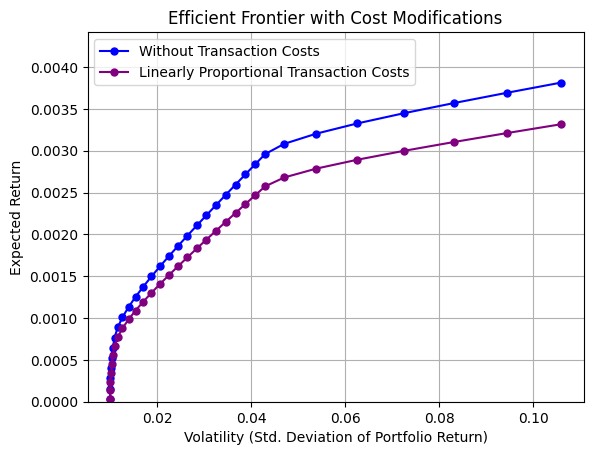

In [46]:
cost_factor = 1.15  # You pay 15% more for one stock (highly linearly proportional setting)
adjusted_mean_returns = mean_returns / cost_factor

# Efficient Frontier computation setup
target_returns_1 = np.linspace(adjusted_mean_returns.min(), adjusted_mean_returns.max(), 100)
risks_1 = []
for t_ret in target_returns_1:
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, adjusted_mean_returns) - t_ret}
    )
    
    # Initial guess (equal distribution)
    init_guess = np.array([1./len(stocks)]*len(stocks))
    
    # Minimize risk for a given return
    opt_res = minimize(minimize_risk, init_guess, args=(adjusted_mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)
    if opt_res.success:
        risks_1.append(portfolio_risk(opt_res.x, adjusted_mean_returns, cov_matrix))
    else:
        print("Optimization failed:", opt_res.message)

# Plotting the efficient frontier


plt.plot(risks, target_returns, marker='o', color='b', linestyle='-', markersize=5, scalex=True, label = "Without Transaction Costs")
plt.plot(risks_1, target_returns_1, marker='o', color="purple", linestyle='-', markersize=5, scalex=True, label = "Linearly Proportional Transaction Costs")


plt.title('Efficient Frontier with Cost Modifications')
plt.xlabel('Volatility (Std. Deviation of Portfolio Return)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.ylim(bottom=0)  # Set the lower limit of the y-axis to 0


# plt.xlim(0.054, 0.06)  # Set the x-axis limits
# plt.ylim(0.0032, 0.0033)  # Set the y-axis limits



plt.legend()

plt.show()


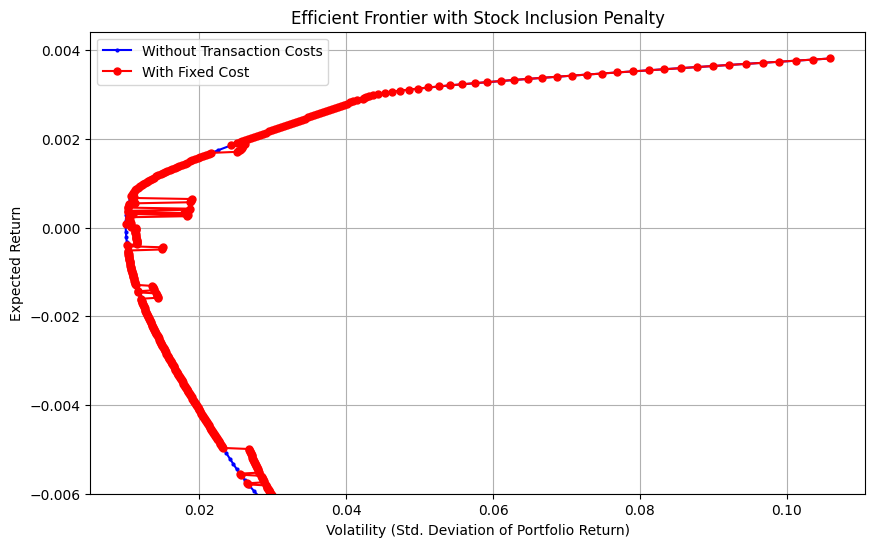

In [47]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Adjustable penalty for including a stock in the portfolio
penalty_factor = 0.002  # Example penalty factor

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to minimize (includes penalty for adding stocks)
def minimize_risk_with_penalty(weights, mean_returns, cov_matrix):
    risk = portfolio_risk(weights, mean_returns, cov_matrix)
    penalty = penalty_factor * sum(weights > 1e-5)  # Adding a small threshold to count non-zero weights
    return risk + penalty

# Constraints
constraints_5 = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1

# Bounds for the weights
bounds = tuple((0, 1) for _ in range(len(stocks)))

# Efficient Frontier computation setup
target_returns_5 = np.linspace(mean_returns.min(), mean_returns.max(), 500)
risks_5 = []

for t_ret in target_returns_5:
    constraints_5 = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - t_ret}
    )
    
    # Initial guess (equal distribution)
    init_guess_5 = np.array([1./len(stocks)]*len(stocks))
    
    # Minimize risk for a given return, considering penalty
    opt_res_5 = minimize(minimize_risk_with_penalty, init_guess_5, args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints_5)
    if opt_res_5.success:
        risks_5.append(portfolio_risk(opt_res_5.x, mean_returns, cov_matrix))
    else:
        print("Optimization failed:", opt_res_5.message)

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, marker='o', color='b', linestyle='-', markersize=2, scalex=True, label = "Without Transaction Costs")
plt.plot(risks_5, target_returns_5, marker='o', color="red", linestyle='-', markersize=5, scalex=True, label = "With Fixed Cost")
plt.title('Efficient Frontier with Stock Inclusion Penalty')
plt.xlabel('Volatility (Std. Deviation of Portfolio Return)')
plt.ylabel('Expected Return')
plt.grid(True)

plt.legend()

plt.ylim(bottom=-0.006)  # Set the lower limit of the y-axis to 0

plt.show()



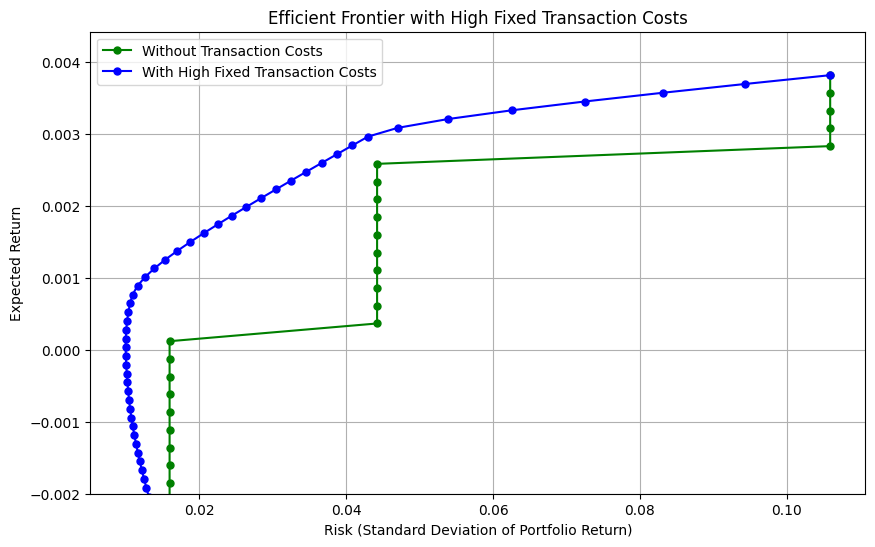

In [48]:

plt.figure(figsize=(10, 6))
plt.plot(risks_a, returns_on_ef_a, marker='o', color="green", linestyle='-', markersize=5, scalex=True, label='Without Transaction Costs')
plt.plot(risks, target_returns, marker='o', color='b', linestyle='-', markersize=5, scalex=True,   label='With High Fixed Transaction Costs')
plt.title('Efficient Frontier with High Fixed Transaction Costs')
plt.xlabel('Risk (Standard Deviation of Portfolio Return)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.ylim(bottom=-0.002)  
plt.legend()
plt.show()